In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, learning_curve, validation_curve
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 80

In [4]:
cars = pd.read_csv('data/preprocessed_data.csv')
print(cars.shape)

(19983, 17)


In [5]:
#Перемешаем данные
cars = cars.sample(frac=1, random_state=RANDOM_STATE)
cars.head()

,label,model,generation,modification,year,mileage,condition,doors_num,body,engine,transmission,color,drive,wheel,package,price,restyling
13070,Toyota,Camry,XV40,167,2007.0,260000.0,не битый,4.0,седан,бензин,механика,чёрный,передний,левый,Base,560000,Нет
3271,Ford,Escape,II,145,2008.0,181000.0,не битый,5.0,внедорожник,бензин,автомат,серый,полный,левый,Base,535000,Нет
18429,ГАЗ,ГАЗель 3302,I,90,2001.0,100000.0,не битый,2.0,фургон,бензин,механика,белый,задний,левый,Base,120000,Нет
18867,ГАЗ,24 Волга,2410,90,1988.0,55000.0,не битый,4.0,седан,бензин,механика,белый,задний,левый,Base,135000,Нет
1367,Chevrolet,Niva,I,80,2011.0,90000.0,не битый,5.0,внедорожник,бензин,механика,зелёный,полный,левый,Bertone Edition,310000,Да


In [6]:
CATEGORICAL_FEATURES = ['label', 'model', 'generation', 'body', 'engine',
                        'transmission', 'color', 'drive', 'wheel', 'package']

NUMERIC_FEATURES = ['modification', 'year', 'mileage', 'doors_num']

In [7]:
def preprocess_categorical_features(dataframe):
    
    # Преобразование бинарных признаков
    lb = LabelBinarizer()
    dataframe['condition'] = lb.fit_transform(dataframe['condition'])
    dataframe['restyling'] = lb.fit_transform(dataframe['restyling'])
    
    # Пребразование категориальных признаков
    dataframe = pd.get_dummies(dataframe, columns=CATEGORICAL_FEATURES)
    print(f"We have {dataframe.shape[1]} features after one-hot encoding")
    return dataframe

In [8]:
def preprocess_numeric_features(X_train, X_test):
    
    scaler = StandardScaler()
    poly = PolynomialFeatures(interaction_only=True)
 
    X_train[NUMERIC_FEATURES] = scaler.fit_transform(X_train[NUMERIC_FEATURES])
    X_test[NUMERIC_FEATURES] = scaler.transform(X_test[NUMERIC_FEATURES])
    
    train_matrix = pd.DataFrame(poly.fit_transform(X_train[NUMERIC_FEATURES]), index=X_train.index)
    test_matrix = pd.DataFrame(poly.transform(X_test[NUMERIC_FEATURES]), index=X_test.index)
    
    return X_train.join(train_matrix), X_test.join(test_matrix)

In [9]:
def make_grid_cv(estimator, params_grid):

    cv = KFold(n_splits=3)
    grid_cv = GridSearchCV(estimator, params_grid, cv=cv, verbose=True)
    return grid_cv

In [10]:
def make_prediction(model, params_fixed, params_grid=None):

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(cars.drop(['price'], axis=1), 
                                                        np.log(cars['price']), test_size=0.3,
                                                        shuffle=True, random_state=RANDOM_STATE)
  
    # Standardize data for linear models
    if model in [Ridge, Lasso, ElasticNet, SGDRegressor]:
        X_train, X_test = preprocess_numeric_features(X_train, X_test)

    estimator = model(**params_fixed)

    if params_grid:
        estimator = make_grid_cv(estimator, params_grid)

    estimator.fit(X_train, y_train)
    y_preds = estimator.predict(X_test)
    print('MSE: ', mean_squared_error(y_test, y_preds))
    print('R2: ', r2_score(y_test, y_preds))
    print('MAE: ', mean_absolute_error(np.exp(y_test), np.exp(y_preds)))
    return estimator, y_test, y_preds

## Baseline (Ridge model with polynomial features)
Посмотрим, какое качество выдаст Ridge-регрессия (линейная регрессия с  𝑅2 -регуляризатором) на имеющихся данных:

In [11]:
cars = preprocess_categorical_features(cars)

We have 1515 features after one-hot encoding


In [12]:
fixed_params = {'random_state': RANDOM_STATE}

In [13]:
print("\tRidge model (Baseline)\n")
make_prediction(Ridge, fixed_params);

	Ridge model (Baseline)

MSE:  0.08868996066108126
R2:  0.8934433034775497
MAE:  64908.07303004497


В среднем Baseline ошибается на 65.000 рублей; хотелось бы снизить MAE до 60.000 рублей.
### Теперь посмотрим на важность признаков, обучив Random Forest
  
  

In [14]:
print("\tRandom Forest (Baseline)\n")
rf, _, _ = make_prediction(RandomForestRegressor, fixed_params)

	Random Forest (Baseline)

MSE:  0.08538285405426707
R2:  0.8974166320532193
MAE:  64420.93128768849


In [15]:
def plot_feature_importance(features, importance):
    
    f, ax = plt.subplots(figsize=(12,6))
    
    feature_weights = pd.DataFrame({'index': features, 'importance': importance})
    feature_weights.sort_values(by=['importance'], ascending=False, inplace=True)
    sns.barplot(x='index', y='importance', data=feature_weights.head(10))
    ax.set_xlabel("")
    ax.set_xlabel("")
    f.tight_layout()
    plt.title("Random Forest feature importance", size=20)
    plt.show()

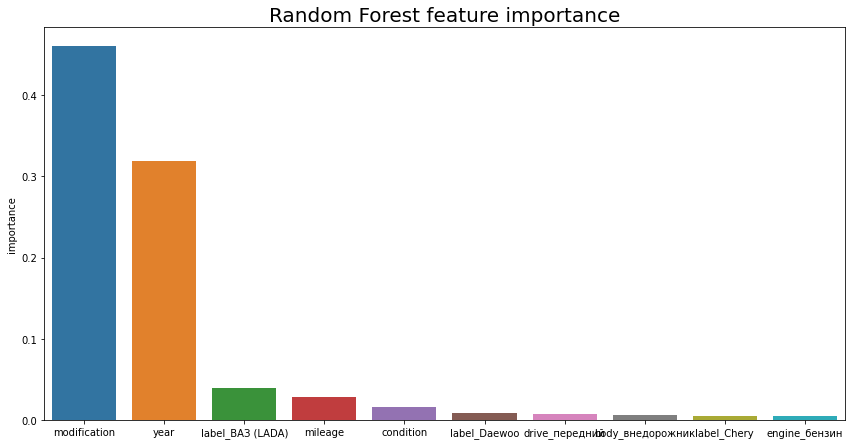

In [16]:
features = cars.drop(['price'], axis=1).columns
plot_feature_importance(features, rf.feature_importances_)

Самые важные признаки - **мощность** и **год выпуска**.  
Добавим признак **car_newness**, который обозначает новизну автомобиля (сколько лет прошло спустя даты выпуска модели):

In [17]:
cars = pd.read_csv('data/preprocessed_data.csv')
cars = cars.sample(frac=1, random_state=RANDOM_STATE)
cars['car_newness'] = 2020 - cars['year']
cars.head()

,label,model,generation,modification,year,mileage,condition,doors_num,body,engine,transmission,color,drive,wheel,package,price,restyling,car_newness
13070,Toyota,Camry,XV40,167,2007.0,260000.0,не битый,4.0,седан,бензин,механика,чёрный,передний,левый,Base,560000,Нет,13.0
3271,Ford,Escape,II,145,2008.0,181000.0,не битый,5.0,внедорожник,бензин,автомат,серый,полный,левый,Base,535000,Нет,12.0
18429,ГАЗ,ГАЗель 3302,I,90,2001.0,100000.0,не битый,2.0,фургон,бензин,механика,белый,задний,левый,Base,120000,Нет,19.0
18867,ГАЗ,24 Волга,2410,90,1988.0,55000.0,не битый,4.0,седан,бензин,механика,белый,задний,левый,Base,135000,Нет,32.0
1367,Chevrolet,Niva,I,80,2011.0,90000.0,не битый,5.0,внедорожник,бензин,механика,зелёный,полный,левый,Bertone Edition,310000,Да,9.0


In [18]:
cars = preprocess_categorical_features(cars)

We have 1516 features after one-hot encoding


In [19]:
print("\tRidge model (with new feature)\n")
make_prediction(Ridge, fixed_params);

	Ridge model (with new feature)

MSE:  0.08869073717821754
R2:  0.8934423705297818
MAE:  64906.147623581885


In [20]:
print("\tRandom Forest\n")
rf, _, _ = make_prediction(RandomForestRegressor, fixed_params)

	Random Forest

MSE:  0.08536775592071119
R2:  0.8974347717301724
MAE:  64321.738147459895


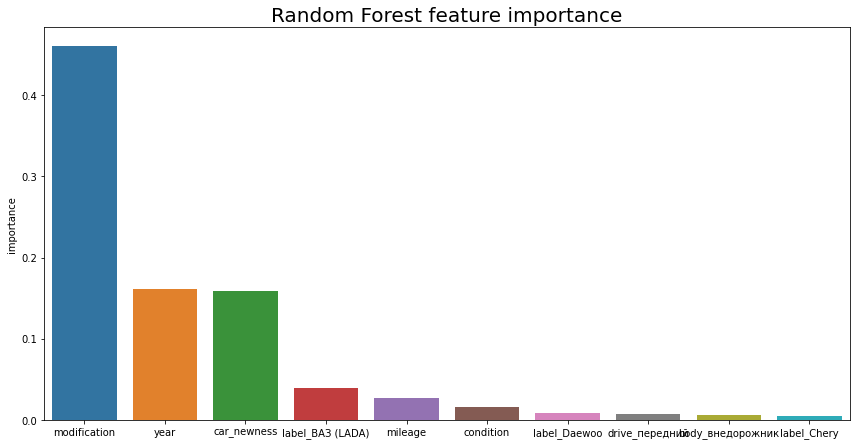

In [21]:
features = cars.drop(['price'], axis=1).columns
plot_feature_importance(features, rf.feature_importances_)

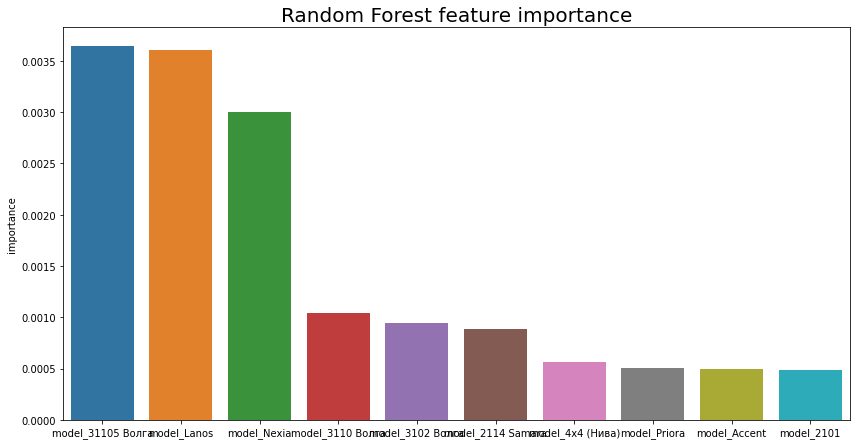

In [22]:
packages_feat = [x for x in features if x.startswith('model')]
indexes = [list(features.values).index(x) for x in packages_feat]
plot_feature_importance(packages_feat, rf.feature_importances_[indexes])

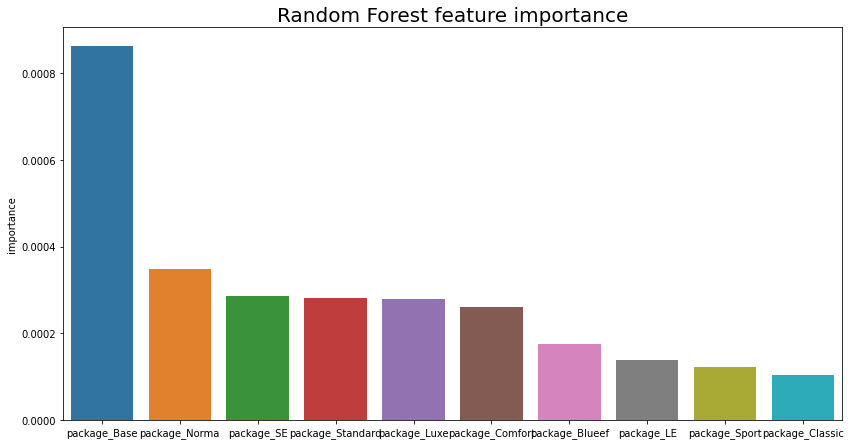

In [23]:
packages_feat = [x for x in features if x.startswith('package')]
indexes = [list(features.values).index(x) for x in packages_feat]
plot_feature_importance(packages_feat, rf.feature_importances_[indexes])

# **Linear models with tuning parameters**
Попробуем подобрать наилучшие параметры для моделей

In [ ]:
print("\tLasso model (GridSearch)\n")
params_grid = {'alpha': np.linspace(1e-05, 1e-03, num=10)}
lr, _, _ = make_prediction(Lasso, fixed_params, params_grid)
print(lr.best_params_)

	Lasso model (GridSearch)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.3min finished


MSE:  0.08401853523479968
R2:  0.8990557951030418
MAE:  62274.20071910179
{'alpha': 1e-05}


In [ ]:
print("\tRidge model (GridSearch)\n")
params_grid = {'alpha': np.linspace(0.9, 2, num=10)}
lr, _, _ = make_prediction(Ridge, fixed_params, params_grid)
print(lr.best_params_)

	Ridge model (GridSearch)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   29.0s finished


MSE:  0.08258162690509722
R2:  0.9007821709372108
MAE:  62986.91223413821
{'alpha': 1.2666666666666666}


In [ ]:
print("\tElasticNet model (GridSearch)\n")
params_grid = {'alpha': np.linspace(1e-05, 1e-04, num=10)}
lr, _, _ = make_prediction(ElasticNet, fixed_params, params_grid)
print(lr.best_params_)

	ElasticNet model (GridSearch)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.2min finished


MSE:  0.08285522192101975
R2:  0.9004534597633146
MAE:  63130.88190086126
{'alpha': 4e-05}


# **Xgboost Tuning**
Построим градиентный бустинг

In [ ]:
import xgboost as xgb

In [ ]:
def valid_curves_plot(hyperparam, param_range):
    
    X = cars.drop(['price'], axis=1)
    y = np.log(cars['price'])

    train_scores, test_scores = validation_curve(xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1), 
                                                 X, y, param_name=hyperparam, param_range=param_range, 
                                                 cv=3, n_jobs=-1, scoring='r2')

    train_scores_mean, train_scores_std  = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
    test_scores_mean, test_scores_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)
    
    plt.figure(figsize=(9,6))
    plt.title('Validation curves for xgbRegressor')
    plt.xlabel(hyperparam); plt.ylabel('R2')
    plt.ylim(0.7, 1.0)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, \
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.plot(param_range, train_scores_mean, label='Training score', color="r", marker='o')
    plt.fill_between(param_range, test_scores_mean - test_scores_std, \
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(param_range, test_scores_mean, label='Validation score', color="g", marker='o')
    plt.legend(loc="best")
    plt.xticks(param_range)
    plt.show()

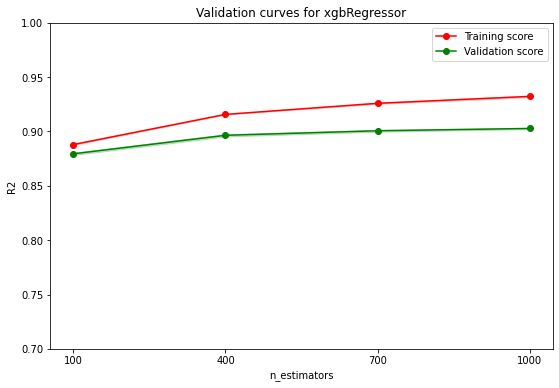

CPU times: user 492 ms, sys: 96 ms, total: 588 ms
Wall time: 33min 46s


In [ ]:
%%time
valid_curves_plot(hyperparam='n_estimators', param_range=[100, 400, 700, 1000])

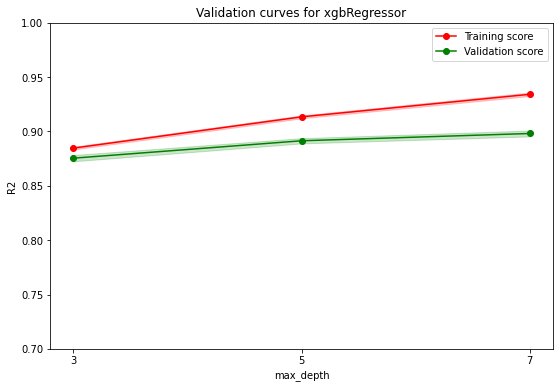

CPU times: user 332 ms, sys: 110 ms, total: 442 ms
Wall time: 6min 54s


In [ ]:
%%time
valid_curves_plot(hyperparam='max_depth', param_range=[3, 5, 7])

In [ ]:
def plot_learning_curve(clf, scoring='r2', cv=5):

    X = cars.drop(['price'], axis=1)
    y = np.log(cars['price'])
    train_sizes = np.arange(0.1, 1, 0.1)
    n_train, train_scores, test_scores = learning_curve(clf, X, y, groups=None, train_sizes=train_sizes,
                                                        cv=cv, scoring=scoring)
    
    plt.figure(figsize=(9,6))
    plt.title('Learning curves for xgbRegressor')
    plt.plot(n_train, train_scores.mean(axis=1), label='train', marker='o', c='green')
    plt.plot(n_train, test_scores.mean(axis=1), label='validation', marker='o', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

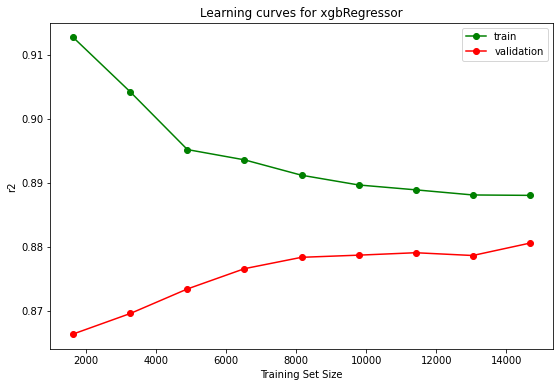

In [ ]:
estimator = xgb.XGBRegressor(**fixed_params, objective='reg:squarederror')
plot_learning_curve(estimator)

- Чем больше тренировочных данных, тем меньше модель переобучается

## Best model 

In [ ]:
%%time
print("\tXGBregressor\n")
fixed_params = {'random_state': RANDOM_STATE, 'n_estimators': 1800,
                'gamma': 0, 'learning_rate': 0.05, 
                'max_depth': 5,
                'min_child_weight': 2,
                'objective': 'reg:squarederror',
                'reg_alpha': 0.75, 'reg_lambda': 0.5,
                'subsample': 0.7}
estimator, y_true, y_preds = make_prediction(xgb.XGBRegressor, fixed_params)

	XGBregressor

MSE:  0.07836615077249649
R2:  0.9058468615471851
MAE:  60652.88700642462
CPU times: user 25min 59s, sys: 320 ms, total: 25min 59s
Wall time: 26min


In [ ]:
predictions_frame = pd.DataFrame({'true': np.exp(y_true), 'predictions': np.exp(y_preds)})
predictions_frame.head(20).T

,8953,8462,1976,17125,1623,14950,2065,17432,14966,14541,14997,3303,2815,16166,57,14281,12567,11602,18182,18192
true,130000.00000,60000.00000,470000.00000,700000.000000,210000.00000,110000.000000,299000.0000,455000.00000,40000.000000,700000.0000,30000.000000,235000.00000,100000.00000,35000.000000,2700000.0,1650000.00,210000.00000,830000.000,219990.000,570000.00000
predictions,172716.90625,40020.34375,488223.65625,43553.507812,165182.59375,104939.484375,304049.4375,458399.65625,40359.003906,867598.9375,53408.796875,289361.15625,118089.40625,39359.101562,2217544.0,1675554.25,165349.65625,815271.625,193476.375,473978.53125


В целом, лучшая построенная модель в среднем ошибается на 60.000 рублей; Как видно из таблицы, модель достаточно неплохо предсказывает цену автомобиля.
Идеи для повышения точности:
- Во-первых, следует увеличить объем тренировочных данных. Например, можно каждый день парсить новые объявления, пока в датасете не будет 50К объявлений.
- Из графика Feature importance видно, что самым значимым признаком для модели является **modification** (мощность автомобиля в л.с.). Предположительно, наличие в датасете технических характеристик, которые связаны с мощностью, таких как *Объем двигателя*, *Разгон до 100 км* увеличат точность модели.
- Более тщательный перебор лучших параметров для моделей.
- Блендинг моделей.